# Statistical Physics numerical project

##### Libraries

In [84]:
import numpy as np
import matplotlib.pyplot as plt

##### constants

In [85]:
from scipy.constants import k #Boltzmann
T = 1/k # 273 + 727

##### Functions

In [86]:
#Wall attraction potential
def V_x(r, K, L):
    if r[0] > L:
        return K*(r[0] - L)**2 / 2
    elif r[0] < 0:
        return K*r[0]**2 / 2
    else:
        return 0
    
def V_y(r, K, L):
    if r[1] > L:
        return K*(r[1] - L)**2 / 2
    elif r[1] < 0:
        return K*r[1]**2 / 2
    else:
        return 0

def V_w(r, K = 1, L = 1):
    return V_x(r, K, L) + V_y(r, K, L)

#Hardcore interaction

def V_h(rij, a = 1, U = 1000*k*T):
    if rij > a:
        return U
    else:
        return 0

#Lennard-Jones interaction
def V_LJ(rij, a = 1, eps = 1):
    return eps * ( (a/rij)**12 - 2*(a/rij)**6)

#no interaction
def no_V(rij):
    return 0

#Hamiltionian, where p,q are shape = (N,2)
def total_H(p, q, V):
    zum = 0
    N = len(p)
    for i in range(N):
        for pi in p[i]:
            zum += pi**2 / (2*m)
        for ri in q[i]:
            zum += V_w(ri)
        for j in range(i + 1, N):
            for component in range(2):
                zum += V(q[i, component] - q[j, component])
    return zum

def total_V(q, V):
    zum = 0
    N = len(q)
    for i in range(N):
        for ri in q[i]:
            zum += V_w(ri)
        for j in range(i + 1, N):
            for component in range(2):
                zum += V(q[i, component] - q[j, component])
    return zum

def calc_E_change(q, new_q, index, V, L):
    change = 0
#     for component in range(2):
#         change += V_w(new_q[index, component]) - V_w(q[index, component])
    change += V_w(new_q[index], L = L) - V_w(q[index], L = L)
    for i in range(0, N):
        if i == index:
            continue
        for component in range(2):
            change += V(new_q[index, component] - new_q[i, component]) - V(q[index, component] - q[i, component])
    return change

In [87]:
def pos_prob(q, V):
    #q is a list of n particles in 2 dim, the potential
    N = len(q)
    V = total_V(q, V)
    return (2*np.pi*m*k*T)**N * np.exp(-zum/(k*T))

In [88]:
def monteCarlo(N, M, V, b, L = 1, init_config = 1.0):
    ### N = number of particles, M = steps, V = potential, b = length of box
    
    #initialising starting config if not given as a parameter
    if np.linalg.norm(init_config) == 1.0:
        config = np.zeros((N, 2))
        for i in range(N):
            x = np.random.uniform(0, 1)
            y = np.random.uniform(0, 1)
            config[i,:] = np.array([x, y])
    else: 
        config = init_config
    plt.title("init config")
    plt.scatter(config[:,0], config[:,1])
        
    for step in range(M):
        rand_select = np.random.randint(0, N)
        r1 = np.random.uniform(0,1)
        r2 = np.random.uniform(0,1)
        pos = config[rand_select]
        x_try = pos[0] + (r1 - 0.5)*b
        y_try = pos[1] + (r2 - 0.5)*b
        new_config = np.copy(config)
        new_config[rand_select,:] = np.array([x_try, y_try])
        
        #calculating change in energy with the posisjon change randomly generated
        change_in_E = calc_E_change(config, new_config, rand_select, V, L)
        if change_in_E <= 0:
            config = new_config
        else:
            random_uni = np.random.uniform(0,1)
            if random_uni < np.exp(-change_in_E/(k*T)):
                config = new_config
                
    return config

##### 1.a)

In [89]:
N = 100
M = 1000*2
Nsim = 10
consentrated_in_middle_config = np.full((N,2), 0.5)
np.shape(consentrated_in_middle_config)

(100, 2)

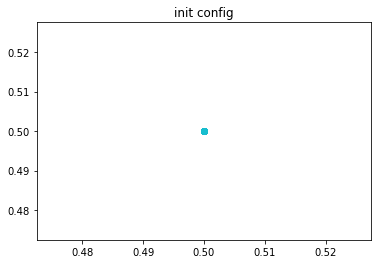

In [91]:
generated_microstates = np.zeros((Nsim, N, 2))
for i in range(Nsim):
    generated_microstates[i] = monteCarlo(N, M, no_V, 0.5, 1, np.copy(consentrated_in_middle_config))

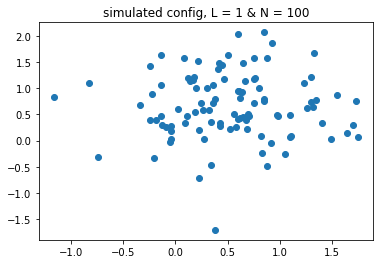

In [92]:
plt.title(f"simulated config, L = {1} & N = {N}")
plt.scatter(generated_microstates[0,:,0], generated_microstates[0,:,1])

We want to calculatet the ensamble avarage over the generated mictrostates given the formula 
$$
P_i = \frac{F}{A} = -\frac{\nabla V}{L^2} = \sum -\frac{\nabla V_i}{L^2}
$$

In [93]:
#Wall attraction force
def F_x(r, K, L):
    if r[0] > L:
        return K*(r[0] - L)
    elif r[0] < 0:
        return K*r[0]
    else:
        return 0
    
def F_y(r, K, L):
    if r[1] > L:
        return K*(r[1] - L)
    elif r[1] < 0:
        return K*r[1]
    else:
        return 0

def F_w(r, K = 1, L = 1):
    return F_x(r, K, L) + F_y(r, K, L)

def total_F(q, V):
    zum = 0
    N = len(q)
    for i in range(N):
        zum += abs(F_w(q[i]))
    return zum

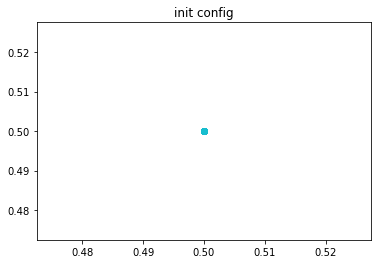

In [119]:
Lvalues = np.linspace(1, 10, 10)
generated_microstates = np.zeros((len(Lvalues),Nsim, N, 2))
count = 0
for L in Lvalues:
    for i in range(Nsim):
        generated_microstates[count, i] = monteCarlo(N, M, no_V, 0.5, L, np.copy(consentrated_in_middle_config))
    count +=1

In [122]:
PLs = np.zeros((len(Lvalues)))
for j in range(len(Lvalues)):
        PLs[j] = sum([total_F(generated_microstates[j,i], no_V) for i in range(len(generated_microstates))])/Lvalues[j]**2

[100.          25.          11.11111111   6.25         4.
   2.77777778   2.04081633   1.5625       1.2345679    1.        ]


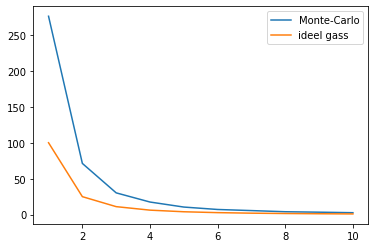

In [123]:
plt.plot(Lvalues, PLs, label = "Monte-Carlo")
def ideel_gass(N, k, T, L):
    return N*k*T/L**2
Pvalues = np.array([ideel_gass(N, k, T, L) for L in Lvalues])
print(Pvalues)
plt.plot(Lvalues, Pvalues, label = "ideel gass")
plt.legend()

##### 1b)

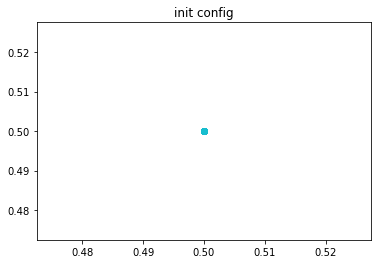

In [124]:
Lvalues = np.linspace(1, 10, 10)
generated_microstates = np.zeros((len(Lvalues),Nsim, N, 2))
count = 0
for L in Lvalues:
    for i in range(Nsim):
        generated_microstates[count, i] = monteCarlo(N, M, V_h, 0.5, L, np.copy(consentrated_in_middle_config))
    count +=1

In [ ]:
plt.plot(Lvalues, PLs, label = "Monte-Carlo")
def var_der_waals_gass(N, k, T, L):
    return N*k*T/L**2
Pvalues = np.array([ideel_gass(N, k, T, L) for L in Lvalues])
print(Pvalues)
plt.plot(Lvalues, Pvalues, label = "ideel gass")
plt.legend()